# Second Part: Kaggle Competition

In [1]:
from datetime import datetime 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm
tqdm.pandas()

from transformers import AutoTokenizer


2022-11-15 22:38:50.821360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 22:38:50.961550: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 22:38:51.491520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alan/.cuda/lib64:/home/alan/.cuda/extras/CUPTI/lib64:/home/alan/.cuda/lib64:/home/alan/.cuda/extras/CUPTI/lib64:
2022-11-15 22:38:51.491643: W tensorflow/stream_executor/platform/default/dso_loader.

## Prepare Data

In [2]:
EMOTION_NAMES = ['joy', 'anticipation', 'trust' , 'sadness' , 'disgust' , 'fear' , 'surprise', 'anger']

## Exploratory Data Analysis

In [3]:
train_data = pd.read_pickle('data/train_data.pkl')
train_labels = pd.read_pickle('data/train_labels.pkl')

data = pd.concat([train_data, train_labels], axis=1)
# data['tweet_id'] = data.index
# data.reset_index(drop=True, inplace=True)
data.head(3)

,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio,emotion
tweet_id,,,,,,,,,,,,,
0x1c7f10,242,2015-05-16 10:36:47,[BlackMirror],o m g Shut Up And Dance though #BlackMirror <LH>,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,joy
0x1c7f11,915,2016-10-15 20:46:37,"[twitch, Destinybeta, Destiny, Destiny2, Desti...",On #twitch <LH> on the #Destinybeta #Destiny #...,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147,anticipation
0x1c7f14,939,2016-07-04 07:22:56,[],A nice sunny wak this morning not many <LH> ar...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,joy


In [4]:
n_sample = 10000
if n_sample < len(data):
  df = data.sample(n=n_sample, random_state=42)
else:
  df = data.copy()

print(len(data), len(df), len(df) / len(data))
print(df.shape)
df.head(3)

1455563 10000 0.006870193870000817
(10000, 13)


,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio,emotion
tweet_id,,,,,,,,,,,,,
0x2f8049,768,2015-08-22 21:15:45,[cantevenmanagefood],Do I have to be an adult today 😭😷 <LH> #cantev...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
0x32eec5,686,2016-05-18 23:19:28,[],@DavidHaydnJones I got a call from casting age...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,joy
0x25a9b8,705,2016-02-12 05:03:29,[],@Skyler23 @DavidSchechter if my screen was tha...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust


### Emotions distribition

In [6]:
df['emotion'].value_counts()

joy             3447
anticipation    1758
trust           1450
sadness         1375
disgust          969
fear             420
surprise         323
anger            258
Name: emotion, dtype: int64

<AxesSubplot: >

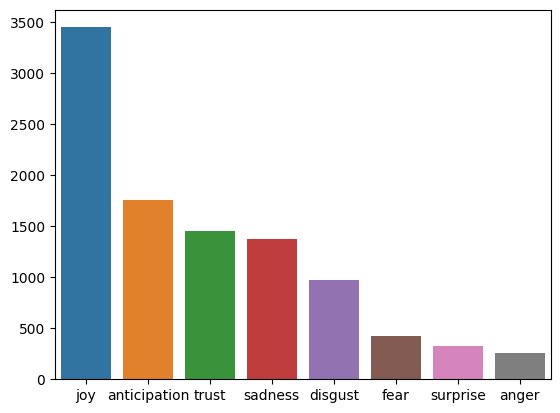

In [8]:
sns.barplot(x=df['emotion'].value_counts().index, y=df['emotion'].value_counts().values)

### Token Length

Maximum token length of the data is less than the model's max_lenght, so we do not need to worry about truncating the data.

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# df['token_len'] = df['text'].map(lambda x: len(tokenizer.encode(x)))
# print(df['token_len'].describe())
# px.histogram(df, x='token_len')

# On all training data
# count    1.455563e+06
# mean     3.142736e+01
# std      1.172646e+01
# min      4.000000e+00
# 25%      2.200000e+01
# 50%      3.100000e+01
# 75%      4.000000e+01
# max      1.590000e+02

### Hashtag

In [ ]:
threshold = 10
tags_count = df['hashtags'].map(lambda x: [tag.lower() for tag in x]).explode().value_counts()
tags_count = tags_count[tags_count > threshold]

no_tag_cnt = df["hashtags"].map(lambda x: len(x)).value_counts()[0]
print(f'# of tags above threshold {threshold}: {len(tags_count)}')
print(f'# of no tags: {no_tag_cnt} ({no_tag_cnt / len(df) * 100 :.2f}%)')
print()
print(tags_count)
px.histogram(tags_count, x=tags_count.index, y=tags_count.values)

In [ ]:
tagsInEmotion = df.groupby('emotion').agg({'hashtags': lambda x: x \
                            .map(lambda x: [tag.lower() for tag in x])
                            .explode()
                            .value_counts().index.tolist()
                          }).T

for emotion in tagsInEmotion.columns:
  print(emotion)
  print(tagsInEmotion[emotion][0][:20])

#### Tag Frequency

In [13]:
tags_count = df['hashtags'].map(lambda x: [tag.lower() for tag in x]).explode().value_counts()
unique_tags = list(tags_count.index.tolist())
tags_count

life            187
love             91
god              89
blessed          50
sad              50
               ... 
lostalum          1
smokemonster      1
hatch             1
kenleung          1
georgeorwell      1
Name: hashtags, Length: 7353, dtype: int64

#### Tags emotions distribution

In [14]:
tagEmoCnt = pd.DataFrame(np.zeros((len(unique_tags), len(EMOTION_NAMES))), index=unique_tags, columns=EMOTION_NAMES, dtype=int)

for tags, emo in df[['hashtags', 'emotion']].values:
  for tag in tags:
    tag = tag.lower()
    tagEmoCnt.loc[tag, emo] += 1

tagEmoCnt

,joy,anticipation,trust,sadness,disgust,fear,surprise,anger
life,69,90,23,2,1,1,1,0
love,90,0,1,0,0,0,0,0
god,4,84,0,0,0,0,0,1
blessed,50,0,0,0,0,0,0,0
sad,0,0,0,50,0,0,0,0
...,...,...,...,...,...,...,...,...
lostalum,0,0,0,0,0,0,1,0
smokemonster,0,0,0,0,0,0,1,0
hatch,0,0,0,0,0,0,1,0
kenleung,0,0,0,0,0,0,1,0


In [15]:
px.bar(tagEmoCnt.iloc[:100], y=tagEmoCnt.columns, height=800)

In [16]:
tagEmoCnt['total'] = tagEmoCnt.sum(axis=1)
for col in EMOTION_NAMES:
  tagEmoCnt[f'{col}_ratio'] = tagEmoCnt[col] / tagEmoCnt['total']

tagEmoCnt

,joy,anticipation,trust,sadness,disgust,fear,surprise,anger,total,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
life,69,90,23,2,1,1,1,0,187,0.368984,0.481283,0.122995,0.010695,0.005348,0.005348,0.005348,0.000000
love,90,0,1,0,0,0,0,0,91,0.989011,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,0.000000
god,4,84,0,0,0,0,0,1,89,0.044944,0.943820,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236
blessed,50,0,0,0,0,0,0,0,50,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sad,0,0,0,50,0,0,0,0,50,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lostalum,0,0,0,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
smokemonster,0,0,0,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
hatch,0,0,0,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
kenleung,0,0,0,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [40]:
# tagEmoCnt.to_csv('eda/tagEmoCnt.csv')

In [54]:
tagEmoCnt = pd.read_csv('eda/tagEmoCnt.csv', index_col=0)
tagEmoCnt

,joy,anticipation,trust,sadness,disgust,fear,surprise,anger,total,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tag,,,,,,,,,,,,,,,,,
life,8995,12912,3118,512,152,195,196,67,26147,0.344017,0.493823,0.119249,0.019582,0.005813,0.007458,0.007496,0.002562
love,13686,198,104,18,3,15,11,3,14038,0.974925,0.014105,0.007408,0.001282,0.000214,0.001069,0.000784,0.000214
god,408,11636,81,16,11,16,4,5,12177,0.033506,0.955572,0.006652,0.001314,0.000903,0.001314,0.000328,0.000411
dream,9,6938,9,3,1,0,3,1,6964,0.001292,0.996267,0.001292,0.000431,0.000144,0.000000,0.000431,0.000144
blessed,6868,24,33,11,0,1,0,0,6937,0.990053,0.003460,0.004757,0.001586,0.000000,0.000144,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dowhatyousayyourgonnado,0,0,0,0,0,0,0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
gwae,1,0,0,0,0,0,0,0,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mightyengland,0,0,1,0,0,0,0,0,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
tagThreshold = 30
sub_tagEmoCnt = tagEmoCnt[tagEmoCnt['total'] > tagThreshold]
sub_tagEmoCnt

,joy,anticipation,trust,sadness,disgust,fear,surprise,anger,total,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tag,,,,,,,,,,,,,,,,,
life,8995,12912,3118,512,152,195,196,67,26147,0.344017,0.493823,0.119249,0.019582,0.005813,0.007458,0.007496,0.002562
love,13686,198,104,18,3,15,11,3,14038,0.974925,0.014105,0.007408,0.001282,0.000214,0.001069,0.000784,0.000214
god,408,11636,81,16,11,16,4,5,12177,0.033506,0.955572,0.006652,0.001314,0.000903,0.001314,0.000328,0.000411
dream,9,6938,9,3,1,0,3,1,6964,0.001292,0.996267,0.001292,0.000431,0.000144,0.000000,0.000431,0.000144
blessed,6868,24,33,11,0,1,0,0,6937,0.990053,0.003460,0.004757,0.001586,0.000000,0.000144,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chic,18,0,11,1,1,0,0,0,31,0.580645,0.000000,0.354839,0.032258,0.032258,0.000000,0.000000,0.000000
progression,15,10,4,1,1,0,0,0,31,0.483871,0.322581,0.129032,0.032258,0.032258,0.000000,0.000000,0.000000
struggleisreal,5,7,2,10,4,0,3,0,31,0.161290,0.225806,0.064516,0.322581,0.129032,0.000000,0.096774,0.000000


In [84]:
emo_ratio_cols = [f'{col}_ratio' for col in EMOTION_NAMES]

def tags_to_emo_ratio(tags):
  tags = [tag.lower() for tag in tags]
  emo_ratio = np.zeros(len(EMOTION_NAMES))
  for tag in tags:
    if tag in sub_tagEmoCnt.index:
      emo_ratio += sub_tagEmoCnt.loc[tag, emo_ratio_cols].values
  return emo_ratio / emo_ratio.sum() if emo_ratio.sum() != 0 else emo_ratio

df_emo_ratio = pd.DataFrame(df['hashtags'].progress_map(tags_to_emo_ratio).tolist(), columns=emo_ratio_cols, index=df.index)
df_emo_ratio

A Jupyter Widget

,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,
0x2f8049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x32eec5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x25a9b8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x2f1906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x2fbd2d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...
0x222e63,0.358209,0.149254,0.417910,0.029851,0.014925,0.014925,0.014925,0.00000
0x317068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x36317a,0.999001,0.000333,0.000333,0.000000,0.000333,0.000000,0.000000,0.00000


In [ ]:
# train_data = pd.read_pickle('data/train_data.pkl')
# test_data = pd.read_pickle('data/test_data.pkl')

In [75]:
# emo_ratio_cols = [f'{col}_ratio' for col in EMOTION_NAMES]
# def tags_to_emo_ratio(tags):
#   tags = [tag.lower() for tag in tags]
#   emo_ratio = np.zeros(len(EMOTION_NAMES))
#   for tag in tags:
#     if tag in sub_tagEmoCnt.index:
#       emo_ratio += sub_tagEmoCnt.loc[tag, emo_ratio_cols].values
#   return emo_ratio / emo_ratio.sum() if emo_ratio.sum() != 0 else emo_ratio

# train_emo_ratio = pd.DataFrame(train_data['hashtags'].progress_map(tags_to_emo_ratio).tolist(), columns=emo_ratio_cols, index=train_data.index)
# test_emo_ratio = pd.DataFrame(test_data['hashtags'].progress_map(tags_to_emo_ratio).tolist(), columns=emo_ratio_cols, index=test_data.index)


,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,,,,,
0x1c7f10,242,2015-05-16 10:36:47,[BlackMirror],o m g Shut Up And Dance though #BlackMirror <LH>,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
0x1c7f11,915,2016-10-15 20:46:37,"[twitch, Destinybeta, Destiny, Destiny2, Desti...",On #twitch <LH> on the #Destinybeta #Destiny #...,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147
0x1c7f14,939,2016-07-04 07:22:56,[],A nice sunny wak this morning not many <LH> ar...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000


In [77]:
# train_emo_ratio.head(3)

,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,
0x1c7f10,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
0x1c7f11,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147
0x1c7f14,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000


In [78]:
# test_emo_ratio.head(3)

,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,
0x1c7f0f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x1c7f12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
0x1c7f13,0.128463,0.103275,0.110831,0.219144,0.355164,0.030227,0.030227,0.02267


In [79]:
# train_emo_ratio.to_pickle(f'data/train_emo_ratio_{}.pkl')
# test_emo_ratio.to_pickle(f'data/test_emo_ratio_{}.pkl')

In [3]:
# train_emo_ratio = pd.read_pickle('data/train_emo_ratio_30.pkl')
# test_emo_ratio = pd.read_pickle('data/test_emo_ratio_30.pkl')
# train_data = pd.read_pickle('data/train_data.pkl')
# test_data = pd.read_pickle('data/test_data.pkl')
# assert len(train_data) == len(train_emo_ratio)
# assert len(test_data) == len(test_emo_ratio)

In [5]:
# new_train_data = pd.concat([train_data, train_emo_ratio], axis=1)
# new_test_data = pd.concat([test_data, test_emo_ratio], axis=1)

In [6]:
# new_train_data.head(3)

,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,,,,,
0x1c7f10,242,2015-05-16 10:36:47,[BlackMirror],o m g Shut Up And Dance though #BlackMirror <LH>,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
0x1c7f11,915,2016-10-15 20:46:37,"[twitch, Destinybeta, Destiny, Destiny2, Desti...",On #twitch <LH> on the #Destinybeta #Destiny #...,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147
0x1c7f14,939,2016-07-04 07:22:56,[],A nice sunny wak this morning not many <LH> ar...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000


In [8]:
# new_train_data.to_pickle('data/train_data.pkl')
# new_test_data.to_pickle('data/test_data.pkl')

### What `_score` means?

### Concatenate hashtags to the end

In [9]:
token = AutoTokenizer.from_pretrained('bert-base-cased')
token.decode(token.encode('#hashtags'))

'[CLS] # hashtags [SEP]'

In [15]:
train_data = pd.read_pickle('data/train_data.pkl')
test_data = pd.read_pickle('data/test_data.pkl')
df = train_data.iloc[:100]
df.head(3)

,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio
tweet_id,,,,,,,,,,,,
0x1c7f10,242,2015-05-16 10:36:47,[BlackMirror],o m g Shut Up And Dance though #BlackMirror <LH>,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
0x1c7f11,915,2016-10-15 20:46:37,"[twitch, Destinybeta, Destiny, Destiny2, Desti...",On #twitch <LH> on the #Destinybeta #Destiny #...,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147
0x1c7f14,939,2016-07-04 07:22:56,[],A nice sunny wak this morning not many <LH> ar...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000


In [25]:
for i in range(30):
  tags = df['hashtags'][i]
  text = df['text'][i]
  print(tags)
  print(text)
  print(np.all([tag in text for tag in tags]))

['BlackMirror']
o m g Shut Up And Dance though #BlackMirror <LH>
True
['twitch', 'Destinybeta', 'Destiny', 'Destiny2', 'DestinytheGame', 'Hunter', 'Titan', 'Warlock', 'Destiny2theGame', 'Beta', 'Destiny2Beta', 'PS4']
On #twitch <LH> on the #Destinybeta #Destiny #Destiny2 #DestinytheGame #Hunter #Titan #Warlock #Destiny2theGame #Beta #Destiny2Beta #PS4
True
[]
A nice sunny wak this morning not many <LH> aroud, a few whites only. Then time in the Garden weeding, it really needed it. :)
True
['Confession', 'NationalCandyCornDay', 'CouldEatThemAllDay', 'NoShame', 'DontJudge']
I'm one of those people who love candy corn... a lot. 😁😂 #Confession <LH> #NationalCandyCornDay #CouldEatThemAllDay #NoShame #DontJudge
True
[]
@metmuseum What are these? They look like something toddlers make at summer camp with junk beads. <LH>
True
['LawOfAttraction', 'ask', 'receive', 'dreambig']
Postive thinking is the only way to go followed by faith <LH> #LawOfAttraction <LH> #ask <LH> #receive #dreambig
True
[

: 

In [19]:
df['text_with_hashtags'] = df['text'] + ' hashtags: ' + df['hashtags'].map(lambda x: ' '.join([f'#{tag}' for tag in x]))
df.head(3)

/tmp/ipykernel_1836170/68650608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_with_hashtags'] = df['text'] + ' hashtags: ' + df['hashtags'].map(lambda x: ' '.join([f'#{tag}' for tag in x]))


,_score,_crawldate,hashtags,text,joy_ratio,anticipation_ratio,trust_ratio,sadness_ratio,disgust_ratio,fear_ratio,surprise_ratio,anger_ratio,text_with_hashtags
tweet_id,,,,,,,,,,,,,
0x1c7f10,242,2015-05-16 10:36:47,[BlackMirror],o m g Shut Up And Dance though #BlackMirror <LH>,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,o m g Shut Up And Dance though #BlackMirror <L...
0x1c7f11,915,2016-10-15 20:46:37,"[twitch, Destinybeta, Destiny, Destiny2, Desti...",On #twitch <LH> on the #Destinybeta #Destiny #...,0.342294,0.217874,0.122447,0.133297,0.10949,0.028613,0.014516,0.03147,On #twitch <LH> on the #Destinybeta #Destiny #...
0x1c7f14,939,2016-07-04 07:22:56,[],A nice sunny wak this morning not many <LH> ar...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,A nice sunny wak this morning not many <LH> ar...


# Processing Data

In [ ]:
ident = pd.read_csv('data/data_identification.csv', index_col='tweet_id')
labels = pd.read_csv('data/emotion.csv', index_col='tweet_id')

print('train size', ident[ident['identification'] == 'train'].shape)
print('test  size', ident[ident['identification'] == 'test'].shape)

print(ident.head(3))
print(labels.head(3))

In [ ]:
train_idxs = ident[ident['identification'] == 'train'].index
train_labels = labels.loc[train_idxs, 'emotion']

train_labels.head(3)

In [ ]:
data = pd.read_json('data/tweets_DM.json', lines=True)

# drop useless columns (only 1 unique value)
data = data.drop(columns=['_index', '_type'])
source = data['_source']

# parsing tweet
def parse_source(data):
    data = data['tweet']
    parsed_data = {}
    for key, value in data.items():
      parsed_data[key] = value
    return parsed_data
tweet = pd.DataFrame(source.map(parse_source).tolist())
data = pd.concat([data, tweet], axis=1)
data = data.drop(columns=['_source'])

data.set_index('tweet_id', inplace=True)

data.head(3)

In [ ]:
train_data = data.loc[train_idxs, :].sort_values(by='tweet_id')
test_data = data.loc[~data.index.isin(train_idxs), :].sort_values(by='tweet_id')
train_labels = train_labels.sort_index()

assert len(train_data) == len(train_labels)
assert np.all(train_data.index == train_labels.index)
print(len(data))
print(len(train_data), len(test_data))

In [ ]:
# train_data.to_pickle('data/train_data.pkl')
# train_labels.to_pickle('data/train_labels.pkl')
# test_data.to_pickle('data/test_data.pkl')